Self-Consistency Analysis
Folder: ../outputs
Excluding: medcalc-llama, meta-llama
--------------------------------------------------------------------------------
  Default file: BytedTsinghua-SIA_DAPO-Qwen-32B_thoughts_to_BytedTsinghua-SIA_DAPO-Qwen-32B_zero_shot_full.jsonl
  Default file: BytedTsinghua-SIA_DAPO-Qwen-32B_thoughts_to_BytedTsinghua-SIA_DAPO-Qwen-32B_zero_shot_without_answer.jsonl
  Sampled file: BytedTsinghua-SIA_DAPO-Qwen-32B_zero_shot_with_sampling.jsonl
  Sampled file: BytedTsinghua-SIA_DAPO-Qwen-32B_zero_shot_with_sampling_without_answer.jsonl
  Default file: Qwen_QwQ-32B_thoughts_to_Qwen_QwQ-32B_zero_shot_full.jsonl
  Default file: Qwen_QwQ-32B_thoughts_to_Qwen_QwQ-32B_zero_shot_without_answer.jsonl
  Sampled file: Qwen_QwQ-32B_zero_shot_with_sampling.jsonl
  Sampled file: Qwen_QwQ-32B_zero_shot_with_sampling_without_answer.jsonl
  Default file: nvidia_Nemotron-Research-Reasoning-Qwen-1.5B_thoughts_to_nvidia_Nemotron-Research-Reasoning-Qwen-1.5B_zero_shot_full.json

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


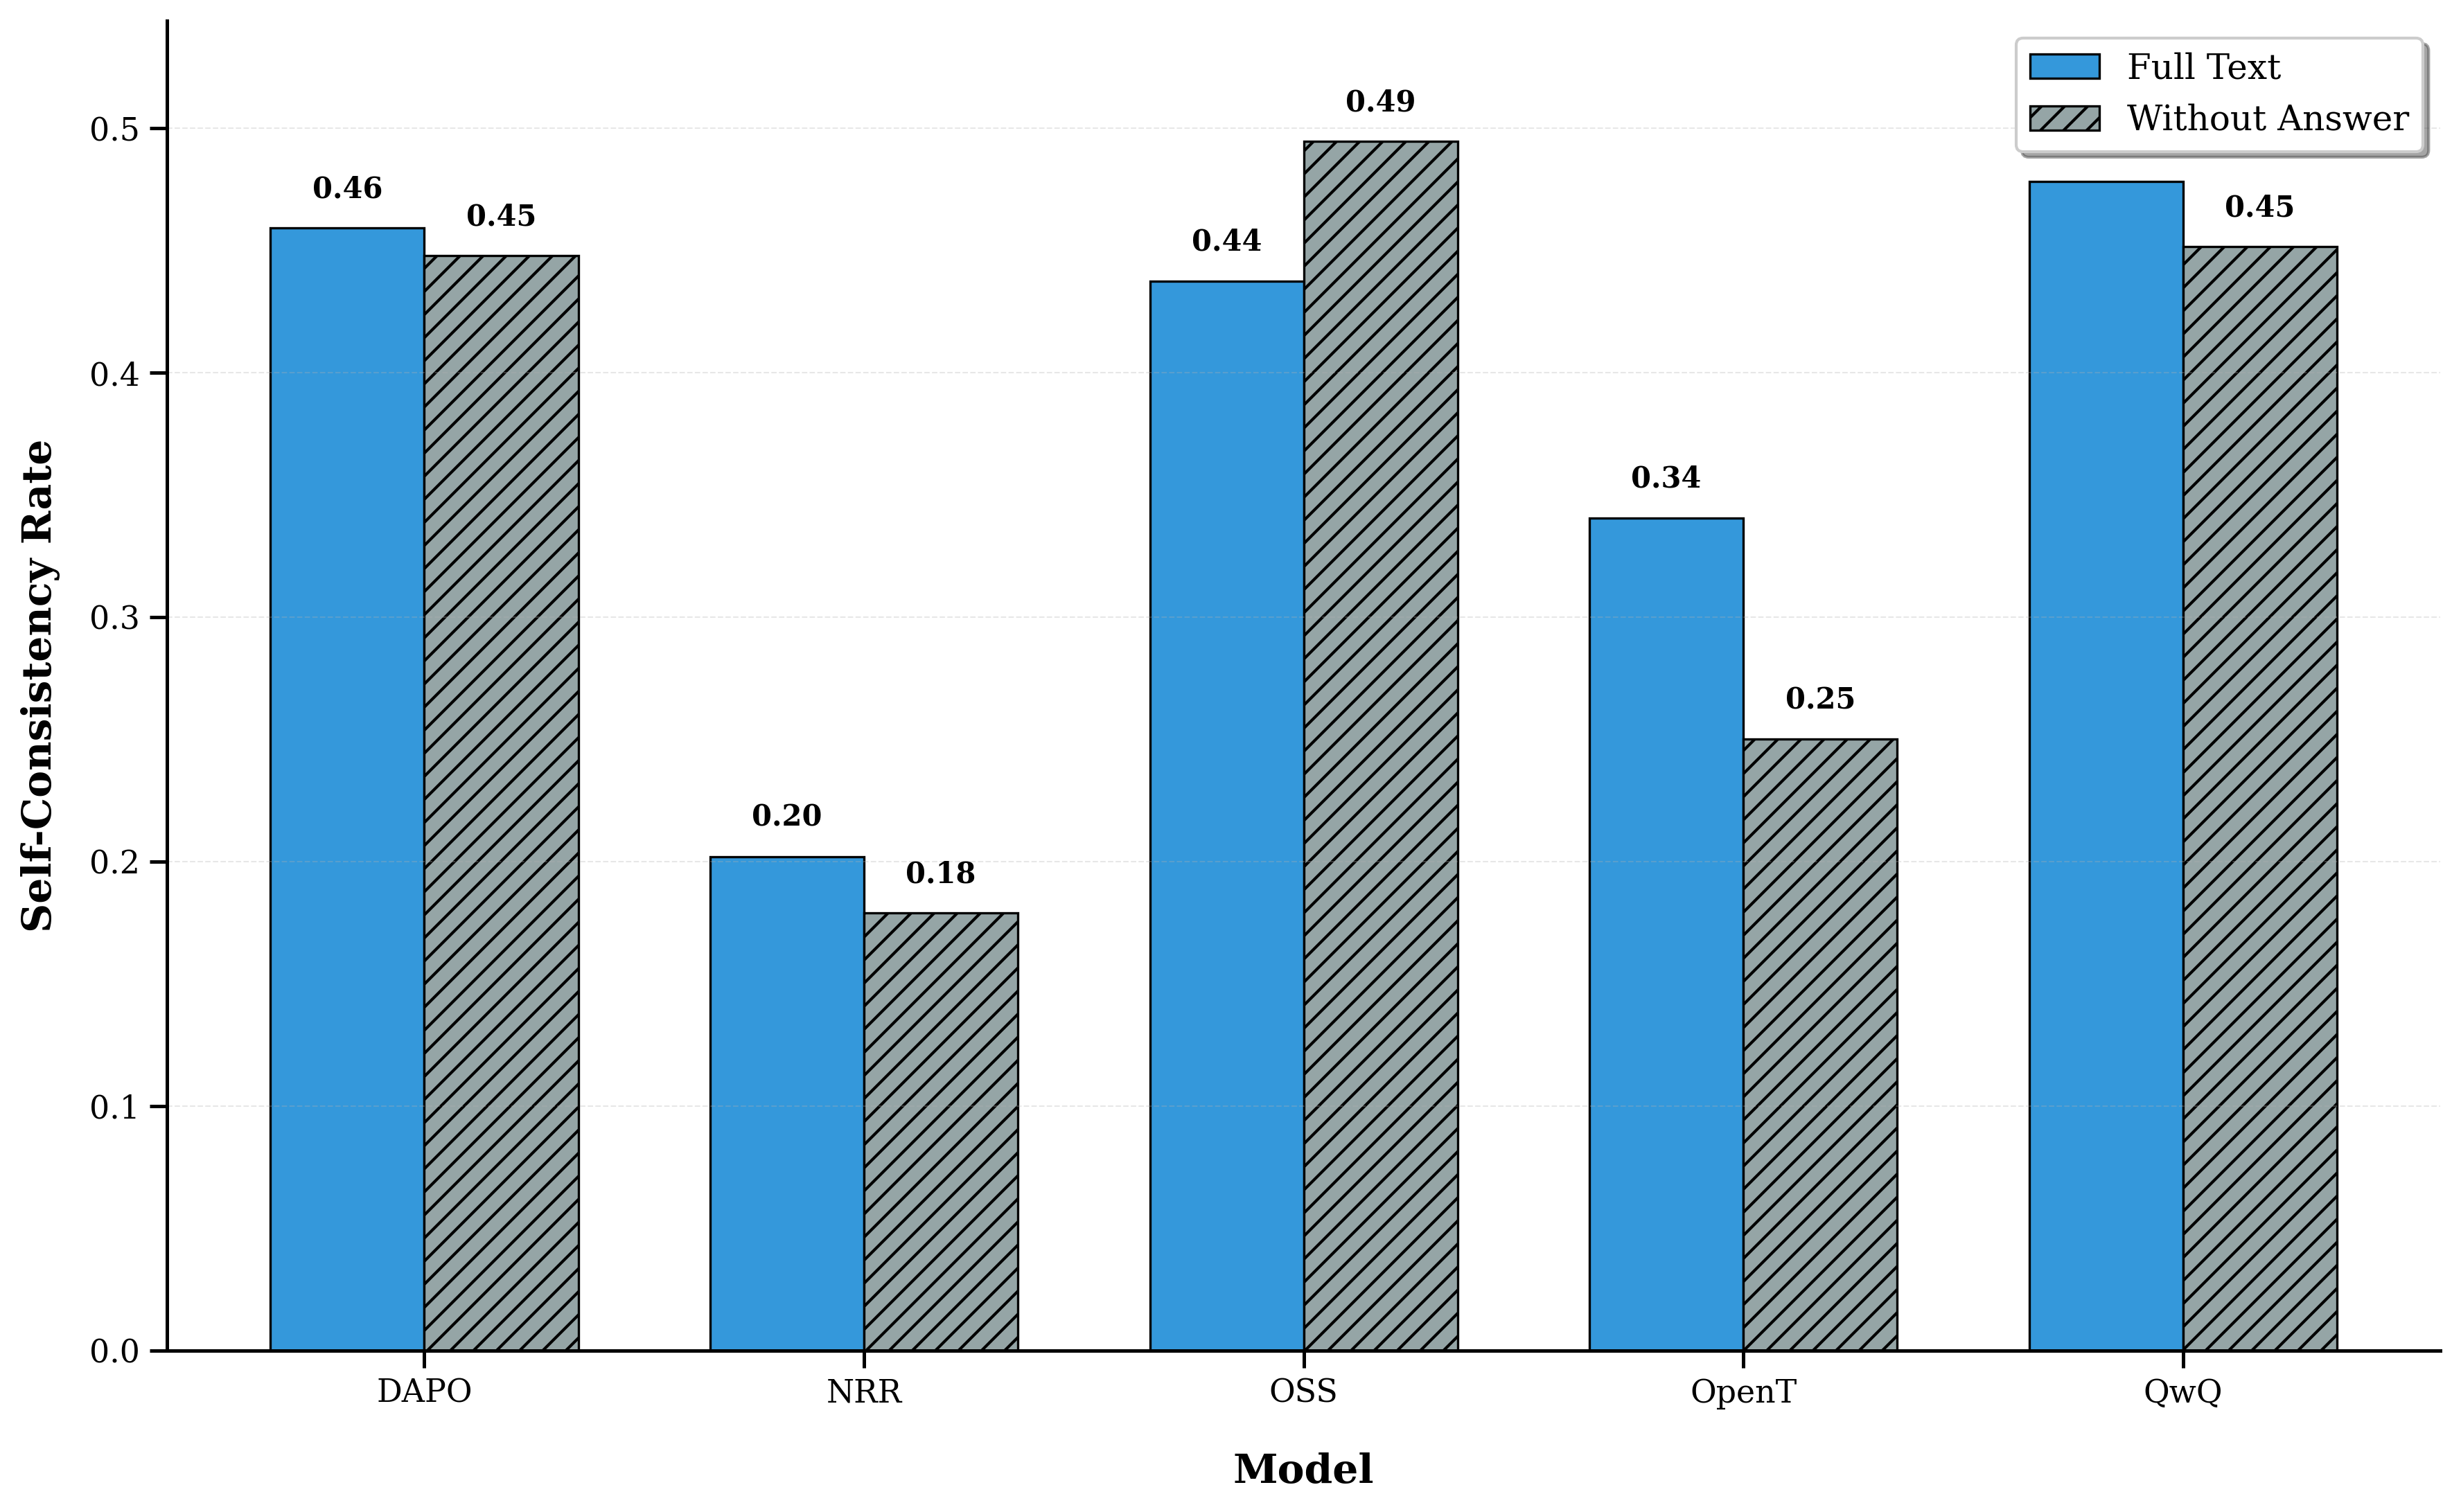


SELF-CONSISTENCY ANALYSIS

WITH ANSWER:
--------------------------------------------------------------------------------
DAPO      : 45.9% (  45/  98 matching)
NRR       : 20.2% (  20/  99 matching)
OSS       : 43.8% (  42/  96 matching)
OpenT     : 34.1% (  31/  91 matching)
QwQ       : 47.8% (  44/  92 matching)

WITHOUT ANSWER:
--------------------------------------------------------------------------------
DAPO      : 44.8% (  43/  96 matching)
NRR       : 17.9% (  17/  95 matching)
OSS       : 49.5% (  46/  93 matching)
OpenT     : 25.0% (  23/  92 matching)
QwQ       : 45.2% (  42/  93 matching)

AVERAGE CONSISTENCY RATES
WITH ANSWER    : 38.4% ± 10.2%
WITHOUT ANSWER : 36.5% ± 12.6%

Analysis complete.


In [2]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'DejaVu Serif'],
    'font.size': 12,
    'figure.dpi': 300
})

MODEL_NAMES = {
    'openai_gpt-oss-20b': 'OSS',
    'BytedTsinghua-SIA_DAPO-Qwen-32B': 'DAPO', 
    'Qwen_QwQ-32B': 'QwQ',
    'open-thoughts_OpenThinker-7B': 'OpenT',
    'nvidia_Nemotron-Research-Reasoning-Qwen-1.5B': 'NRR'
}

EXCLUDED_MODELS = ['medcalc-llama', 'meta-llama']

def should_exclude_model(name):
    return any(excl in name.lower() for excl in EXCLUDED_MODELS)

def parse_jsonl(filepath):
    try:
        with open(filepath, 'r') as f:
            return [json.loads(line) for line in f if line.strip()]
    except:
        return []

def get_model_name(filename):
    """Extract model name from filename."""
    for model_key, model_short in MODEL_NAMES.items():
        if model_key in filename:
            return model_short
    return None

def is_default_file(filename):
    """Check if file is default (self-transfer) setting."""
    match = re.match(r'(.+)_thoughts_to_(.+)_zero_shot', filename)
    if match:
        source, target = match.group(1), match.group(2)
        return source == target
    return False

def is_sampled_file(filename):
    """Check if file is sampled setting."""
    return '_with_sampling' in filename

def get_answer_condition(filename):
    """Check if file has answer or not."""
    return 'with_answer' if 'without_answer' not in filename else 'without_answer'

def is_correct(datapoint, field_prefix=""):
    """Check if answer is correct."""
    result = datapoint.get(f"{field_prefix}Result", "")
    answer = datapoint.get(f"{field_prefix}Answer" if field_prefix else "LLM Answer", "")
    
    invalid = ["not defined", "N/A", "does not match", "are not permitted"]
    return None if any(marker in str(answer) for marker in invalid) else result == "Correct"

def calculate_consistency(default_data, sampled_data):
    """Calculate self-consistency rate (proportion of matching answers)."""
    matching = 0
    total_valid = 0
    matching_correct = 0
    matching_wrong = 0
    
    for default_dp, sampled_dp in zip(default_data, sampled_data):
        default_correct = is_correct(default_dp, "Target ")
        sampled_correct = is_correct(sampled_dp)
        
        if default_correct is None or sampled_correct is None:
            continue
        
        default_answer = default_dp.get("Target Answer", "")
        sampled_answer = sampled_dp.get("LLM Answer", "")
        
        total_valid += 1
        
        # Both correct = matching (regardless of exact answer text)
        if default_correct and sampled_correct:
            matching += 1
            matching_correct += 1
        # Both wrong = matching only if exact answers match
        elif not default_correct and not sampled_correct:
            if default_answer == sampled_answer:
                matching += 1
                matching_wrong += 1
        # One correct, one wrong = not matching (don't increment)
    
    print(f"    Total valid: {total_valid}")
    print(f"    Total matching: {matching}")
    print(f"    Matching correct: {matching_correct}")
    print(f"    Matching wrong: {matching_wrong}")
    
    return matching / total_valid if total_valid > 0 else 0, matching, total_valid

def analyze_self_consistency(folder_path):
    """Analyze self-consistency across models."""
    if not os.path.exists(folder_path):
        return {}
    
    model_files = defaultdict(lambda: defaultdict(dict))
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jsonl') or should_exclude_model(filename):
            continue
        
        model = get_model_name(filename)
        if not model:
            continue
        
        condition = get_answer_condition(filename)
        
        if is_default_file(filename):
            print(f"  Default file: {filename}")
            model_files[model][condition]['default'] = filename
        elif is_sampled_file(filename):
            print(f"  Sampled file: {filename}")
            model_files[model][condition]['sampled'] = filename
    
    results = defaultdict(dict)
    
    for model, conditions in model_files.items():
        for condition, files in conditions.items():
            if 'default' not in files or 'sampled' not in files:
                continue
            
            print(f"\n{model} - {condition}:")
            print(f"  Default file: {files['default']}")
            print(f"  Sampled file: {files['sampled']}")
            
            default_data = parse_jsonl(os.path.join(folder_path, files['default']))
            sampled_data = parse_jsonl(os.path.join(folder_path, files['sampled']))
            
            print(f"  Default data length: {len(default_data)}")
            print(f"  Sampled data length: {len(sampled_data)}")
            
            if len(default_data) == len(sampled_data) and len(default_data) > 0:
                
                rate, matching, total = calculate_consistency(default_data, sampled_data)
                
                if total > 0:
                    results[model][condition] = {
                        'rate': rate,
                        'matching': matching,
                        'total': total
                    }
    
    return results

def plot_consistency_analysis(results):
    """Plot self-consistency rates."""
    models = sorted(results.keys())
    
    if not models:
        print("No data found")
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(models))
    width = 0.35
    
    with_answer = [results[m]['with_answer']['rate'] if 'with_answer' in results[m] else 0 
                   for m in models]
    without_answer = [results[m]['without_answer']['rate'] if 'without_answer' in results[m] else 0 
                     for m in models]
    
    bars1 = ax.bar(x - width/2, with_answer, width, label='Full Text', 
                   color='#3498db', edgecolor='black', linewidth=0.8)
    bars2 = ax.bar(x + width/2, without_answer, width, label='Without Answer',
                   color='#95a5a6', edgecolor='black', linewidth=0.8, hatch='///')
    
    for bars, values in [(bars1, with_answer), (bars2, without_answer)]:
        for bar, val in zip(bars, values):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{val:.2f}', ha='center', va='bottom', 
                       fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Model', fontweight='bold', fontsize=14, labelpad=15)
    ax.set_ylabel('Self-Consistency Rate', fontweight='bold', fontsize=14, labelpad=10)
    # ax.set_title('Self-Consistency: Default vs Sampled Answers', 
    #             fontweight='bold', pad=20, fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=12)
    
    legend = ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    legend.get_title().set_fontweight('bold')
    
    max_val = max(max(with_answer), max(without_answer))
    ax.set_ylim(0, max_val * 1.1)  # 10% padding above max value
    ax.grid(axis='y', linestyle='--', alpha=0.3, linewidth=0.5)
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.tick_params(axis='both', labelsize=11, width=1.2, length=6)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12, top=0.92)
    plt.savefig('self_consistency.pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.savefig('self_consistency.eps', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()

def print_analysis(results):
    """Print self-consistency statistics."""
    print("\n" + "="*80)
    print("SELF-CONSISTENCY ANALYSIS")
    print("="*80)
    
    for condition in ['with_answer', 'without_answer']:
        print(f"\n{condition.upper().replace('_', ' ')}:")
        print("-" * 80)
        
        models = sorted([m for m in results.keys() if condition in results[m]])
        
        for model in models:
            info = results[model][condition]
            print(f"{model:10s}: {info['rate']:5.1%} ({info['matching']:4d}/{info['total']:4d} matching)")
    
    print("\n" + "="*80)
    print("AVERAGE CONSISTENCY RATES")
    print("="*80)
    
    for condition in ['with_answer', 'without_answer']:
        models = [m for m in results.keys() if condition in results[m]]
        if models:
            rates = [results[m][condition]['rate'] for m in models]
            mean, std = np.mean(rates), np.std(rates)
            print(f"{condition.upper().replace('_', ' '):15s}: {mean:5.1%} ± {std:5.1%}")

def main(folder_path):
    print("Self-Consistency Analysis")
    print(f"Folder: {folder_path}")
    print(f"Excluding: {', '.join(EXCLUDED_MODELS)}")
    print("-" * 80)
    
    results = analyze_self_consistency(folder_path)
    
    if not results:
        print("No data found.")
        return
    
    print(f"Found {len(results)} models with consistency data")
    
    plot_consistency_analysis(results)
    print_analysis(results)
    
    print("\n" + "="*80)
    print("Analysis complete.")
    print("="*80)

if __name__ == "__main__":
    main("../outputs")